<a href="https://colab.research.google.com/github/Shamoyeeta/Adversarial-ML/blob/main/attacks/DF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf


In [ ]:
import os

import numpy as np

import matplotlib
matplotlib.use('Agg')           # noqa: E402
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow.compat.v1 as tf
import time
tf.disable_v2_behavior()



Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
def deepfool(model, x, noise=False, eta=0.02, epochs=3, batch=False,
             clip_min=0.0, clip_max=1.0, min_prob=0.0):
    """DeepFool implementation in Tensorflow.
    The original DeepFool will stop whenever we successfully cross the
    decision boundary.  Thus it might not run total epochs.  In order to force
    DeepFool to run full epochs, you could set batch=True.  In that case the
    DeepFool will run until the max epochs is reached regardless whether we
    cross the boundary or not.  See https://arxiv.org/abs/1511.04599 for
    details.
    :param model: Model function.
    :param x: 2D or 4D input tensor.
    :param noise: Also return the noise if True.
    :param eta: Small overshoot value to cross the boundary.
    :param epochs: Maximum epochs to run.
    :param batch: If True, run in batch mode, will always run epochs.
    :param clip_min: Min clip value for output.
    :param clip_max: Max clip value for output.
    :param min_prob: Minimum probability for adversarial samples.
    :return: Adversarials, of the same shape as x.
    """
    y = tf.stop_gradient(model(x))

    fns = [[_deepfool2, _deepfool2_batch], [_deepfoolx, _deepfoolx_batch]]

    i = int(y.get_shape().as_list()[1] > 1)
    j = int(batch)
    fn = fns[i][j]

    if batch:
        delta = fn(model, x, eta=eta, epochs=epochs, clip_min=clip_min,
                   clip_max=clip_max)
    else:
        def _f(xi):
            xi = tf.expand_dims(xi, axis=0)
            z = fn(model, xi, eta=eta, epochs=epochs, clip_min=clip_min,
                   clip_max=clip_max, min_prob=min_prob)
            return z[0]

        delta = tf.map_fn(_f, x, dtype=(tf.float32), back_prop=False,
                          name='deepfool')

    if noise:
        return delta

    xadv = tf.stop_gradient(x + delta*(1+eta))
    xadv = tf.clip_by_value(xadv, clip_min, clip_max)
    return xadv


def _prod(iterable):
    ret = 1
    for x in iterable:
        ret *= x
    return ret

def _deepfool2(model, x, epochs, eta, clip_min, clip_max, min_prob):
    """DeepFool for binary classifiers.
    Note that DeepFools that binary classifier outputs +1/-1 instead of 0/1.
    """
    y0 = tf.stop_gradient(tf.reshape(model(x), [-1])[0])
    y0 = tf.to_int32(tf.greater(y0, 0.0))

    def _cond(i, z):
        xadv = tf.clip_by_value(x + z*(1+eta), clip_min, clip_max)
        y = tf.stop_gradient(tf.reshape(model(xadv), [-1])[0])
        y = tf.to_int32(tf.greater(y, 0.0))
        return tf.logical_and(tf.less(i, epochs), tf.equal(y0, y))

    def _body(i, z):
        xadv = tf.clip_by_value(x + z*(1+eta), clip_min, clip_max)
        y = tf.reshape(model(xadv), [-1])[0]
        g = tf.gradients(y, xadv)[0]
        dx = - y * g / (tf.norm(g) + 1e-10)  # off by a factor of 1/norm(g)
        return i+1, z+dx

    _, noise = tf.while_loop(_cond, _body, [0, tf.zeros_like(x)],
                             name='_deepfool2', back_prop=False)
    return noise


def _deepfool2_batch(model, x, epochs, eta, clip_min, clip_max):
    """DeepFool for binary classifiers in batch mode.
    """
    xshape = x.get_shape().as_list()[1:]
    dim = _prod(xshape)

    def _cond(i, z):
        return tf.less(i, epochs)

    def _body(i, z):
        xadv = tf.clip_by_value(x + z*(1+eta), clip_min, clip_max)
        y = tf.reshape(model(xadv), [-1])
        g = tf.gradients(y, xadv)[0]
        n = tf.norm(tf.reshape(g, [-1, dim]), axis=1) + 1e-10
        d = tf.reshape(-y / n, [-1] + [1]*len(xshape))
        dx = g * d
        return i+1, z+dx

    _, noise = tf.while_loop(_cond, _body, [0, tf.zeros_like(x)],
                             name='_deepfool2_batch', back_prop=False)
    return noise


def _deepfoolx(model, x, epochs, eta, clip_min, clip_max, min_prob):
    """DeepFool for multi-class classifiers.
    Assumes that the final label is the label with the maximum values.
    """
    y0 = tf.stop_gradient(model(x))
    y0 = tf.reshape(y0, [-1])
    k0 = tf.argmax(y0)

    ydim = y0.get_shape().as_list()[0]
    xdim = x.get_shape().as_list()[1:]
    xflat = _prod(xdim)

    def _cond(i, z):
        xadv = tf.clip_by_value(x + z*(1+eta), clip_min, clip_max)
        y = tf.reshape(model(xadv), [-1])
        p = tf.reduce_max(y)
        k = tf.argmax(y)
        return tf.logical_and(tf.less(i, epochs),
                              tf.logical_or(tf.equal(k0, k),
                                            tf.less(p, min_prob)))

    def _body(i, z):
        xadv = tf.clip_by_value(x + z*(1+eta), clip_min, clip_max)
        y = tf.reshape(model(xadv), [-1])

        gs = [tf.reshape(tf.gradients(y[i], xadv)[0], [-1])
              for i in range(ydim)]
        g = tf.stack(gs, axis=0)

        yk, yo = y[k0], tf.concat((y[:k0], y[(k0+1):]), axis=0)
        gk, go = g[k0], tf.concat((g[:k0], g[(k0+1):]), axis=0)

        yo.set_shape(ydim - 1)
        go.set_shape([ydim - 1, xflat])

        a = tf.abs(yo - yk)
        b = go - gk
        c = tf.norm(b, axis=1)
        score = a / c
        ind = tf.argmin(score)

        si, bi = score[ind], b[ind]
        dx = si * bi
        dx = tf.reshape(dx, [-1] + xdim)
        return i+1, z+dx

    _, noise = tf.while_loop(_cond, _body, [0, tf.zeros_like(x)],
                             name='_deepfoolx', back_prop=False)
    return noise


def _deepfoolx_batch(model, x, epochs, eta, clip_min, clip_max):
    """DeepFool for multi-class classifiers in batch mode.
    """
    y0 = tf.stop_gradient(model(x))
    B, ydim = tf.shape(y0)[0], y0.get_shape().as_list()[1]

    k0 = tf.argmax(y0, axis=1, output_type=tf.int32)
    k0 = tf.stack((tf.range(B), k0), axis=1)

    xshape = x.get_shape().as_list()[1:]
    xdim = _prod(xshape)

    perm = list(range(len(xshape) + 2))
    perm[0], perm[1] = perm[1], perm[0]

    def _cond(i, z):
        return tf.less(i, epochs)

    def _body(i, z):
        xadv = tf.clip_by_value(x + z*(1+eta), clip_min, clip_max)
        y = model(xadv)

        gs = [tf.gradients(y[:, i], xadv)[0] for i in range(ydim)]
        g = tf.stack(gs, axis=0)
        g = tf.transpose(g, perm)

        yk = tf.expand_dims(tf.gather_nd(y, k0), axis=1)
        gk = tf.expand_dims(tf.gather_nd(g, k0), axis=1)

        a = tf.abs(y - yk)
        b = g - gk
        c = tf.norm(tf.reshape(b, [-1, ydim, xdim]), axis=-1)

        # Assume 1) 0/0=tf.nan 2) tf.argmin ignores nan
        score = a / c

        ind = tf.argmin(score, axis=1, output_type=tf.int32)
        ind = tf.stack((tf.range(B), ind), axis=1)

        si, bi = tf.gather_nd(score, ind), tf.gather_nd(b, ind)
        si = tf.reshape(si, [-1] + [1]*len(xshape))
        dx = si * bi
        return i+1, z+dx

    _, noise = tf.while_loop(_cond, _body, [0, tf.zeros_like(x)],
                             name='_deepfoolx_batch', back_prop=False)
    return noise


In [ ]:
img_size = 28
img_chan = 1
n_classes = 10
maxTime = 0

In [ ]:
print('\nLoading MNIST')

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.reshape(X_train, [-1, img_size, img_size, img_chan])
X_train = X_train.astype(np.float32) / 255
X_test = np.reshape(X_test, [-1, img_size, img_size, img_chan])
X_test = X_test.astype(np.float32) / 255

to_categorical = tf.keras.utils.to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('\nSpliting data')

ind = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[ind], y_train[ind]

VALIDATION_SPLIT = 0.1
n = int(X_train.shape[0] * (1-VALIDATION_SPLIT))
X_valid = X_train[n:]
X_train = X_train[:n]
y_valid = y_train[n:]
y_train = y_train[:n]



Loading MNIST

Spliting data


In [ ]:
print('\nConstruction graph')


def model(x, logits=False, training=False):
    with tf.variable_scope('conv0'):
        z = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3],
                             padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.variable_scope('conv1'):
        z = tf.layers.conv2d(z, filters=64, kernel_size=[3, 3],
                             padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.variable_scope('flatten'):
        shape = z.get_shape().as_list()
        z = tf.reshape(z, [-1, np.prod(shape[1:])])

    with tf.variable_scope('mlp'):
        z = tf.layers.dense(z, units=128, activation=tf.nn.relu)
        z = tf.layers.dropout(z, rate=0.25, training=training)

    logits_ = tf.layers.dense(z, units=10, name='logits')
    y = tf.nn.softmax(logits_, name='ybar')

    if logits:
        return y, logits_
    return y



Construction graph


In [ ]:
class Dummy:
    pass


env = Dummy()


In [ ]:
with tf.compat.v1.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, img_size, img_size, img_chan),
                           name='x')
    env.y = tf.placeholder(tf.float32, (None, n_classes), name='y')
    env.training = tf.placeholder_with_default(False, (), name='mode')

    env.ybar, logits = model(env.x, logits=True, training=env.training)

    with tf.variable_scope('acc'):
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')

    with tf.variable_scope('loss'):
        xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                       logits=logits)
        env.loss = tf.reduce_mean(xent, name='loss')

    with tf.variable_scope('train_op'):
        optimizer = tf.train.AdamOptimizer()
        env.train_op = optimizer.minimize(env.loss)

    env.saver = tf.train.Saver()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.dense` is deprecated and will be removed 

In [ ]:
with tf.compat.v1.variable_scope('model', reuse=True):
    env.adv_epochs = tf.placeholder(tf.int32, (), name='adv_epochs')
    env.xadv = deepfool(model, env.x, epochs=env.adv_epochs)

print('\nInitializing graph')

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.dense` is deprecated and will be removed 


Initializing graph


In [ ]:
def evaluate(sess, env, X_data, y_data, batch_size=128):
    """
    Evaluate TF model by running env.loss and env.acc.
    """
    print('\nEvaluating')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    loss, acc = 0, 0

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        cnt = end - start
        batch_loss, batch_acc = sess.run(
            [env.loss, env.acc],
            feed_dict={env.x: X_data[start:end],
                       env.y: y_data[start:end]})
        loss += batch_loss * cnt
        acc += batch_acc * cnt
    loss /= n_sample
    acc /= n_sample

    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc


def train(sess, env, X_data, y_data, X_valid=None, y_valid=None, epochs=1,
          load=False, shuffle=True, batch_size=128, name='model'):
    """
    Train a TF model by running env.train_op.
    """
    if load:
        if not hasattr(env, 'saver'):
            return print('\nError: cannot find saver op')
        print('\nLoading saved model')
        return env.saver.restore(sess, 'model/{}'.format(name))

    print('\nTrain model')
    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    for epoch in range(epochs):
        print('\nEpoch {0}/{1}'.format(epoch + 1, epochs))

        if shuffle:
            print('\nShuffling data')
            ind = np.arange(n_sample)
            np.random.shuffle(ind)
            X_data = X_data[ind]
            y_data = y_data[ind]

        for batch in range(n_batch):
            print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
            start = batch * batch_size
            end = min(n_sample, start + batch_size)
            sess.run(env.train_op, feed_dict={env.x: X_data[start:end],
                                              env.y: y_data[start:end],
                                              env.training: True})
        if X_valid is not None:
            evaluate(sess, env, X_valid, y_valid)

    if hasattr(env, 'saver'):
        print('\n Saving model')
        os.makedirs('model', exist_ok=True)
        env.saver.save(sess, 'model/{}'.format(name))


In [ ]:
def predict(sess, env, X_data, batch_size=128):
    """
    Do inference by running env.ybar.
    """
    print('\nPredicting')
    n_classes = env.ybar.get_shape().as_list()[1]

    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    yval = np.empty((n_sample, n_classes))

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        y_batch = sess.run(env.ybar, feed_dict={env.x: X_data[start:end]})
        yval[start:end] = y_batch
    print()
    return yval


In [ ]:
def make_deepfool(sess, env, X_data, epochs=1, eps=0.01, batch_size=128):
    """
    Generate DeepFool by running env.xadv.
    """
    print('\nMaking adversarials via DeepFool')
    global maxTime

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        tick = time.perf_counter()
        adv = sess.run(env.xadv, feed_dict={env.x: X_data[start:end],
                                            env.adv_epochs: epochs})
        tock = time.perf_counter()
        maxTime = max(maxTime, (tock - tick))
        X_adv[start:end] = adv
    print("Maximum Time " , maxTime)

    return X_adv


In [ ]:
print('\nTraining')

train(sess, env, X_train, y_train, X_valid, y_valid, load=False, epochs=5,
      name='mnist')

print('\nEvaluating on clean data')

evaluate(sess, env, X_test, y_test)

print('\nGenerating adversarial data')

X_adv = make_deepfool(sess, env, X_test, epochs=3)

print('\nEvaluating on adversarial data')

evaluate(sess, env, X_adv, y_test)

print('\nRandomly sample adversarial data from each category')

y1 = predict(sess, env, X_test)
y2 = predict(sess, env, X_adv)

z0 = np.argmax(y_test, axis=1)
z1 = np.argmax(y1, axis=1)
z2 = np.argmax(y2, axis=1)


Training

Train model

Epoch 1/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0625 acc: 0.9808

Epoch 2/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0379 acc: 0.9888

Epoch 3/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0367 acc: 0.9885

Epoch 4/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0364 acc: 0.9893

Epoch 5/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0296 acc: 0.9915

 Saving model

Evaluating on clean data

Evaluating
 loss: 0.0276 acc: 0.9908

Generating adversarial data

Making adversarials via DeepFool
Maximum Time  2.1072560349999776

Evaluating on adversarial data

Evaluating
 loss: 1.6465 acc: 0.1379

Randomly sample adversarial data from each category

Predicting
 batch 79/79

Predicting
 batch 79/79



Plotting results

Saving figure


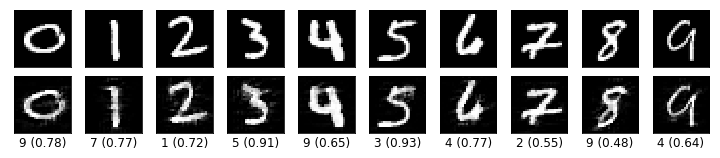

In [ ]:
print('\nPlotting results')
fig = plt.figure(figsize=(10, 2.2))
gs = gridspec.GridSpec(2, 10, wspace=0.05, hspace=0.05)

for i in range(10):
    ind, = np.where(np.all([z0 == i, z1 == i, z2 != i], axis=0))
    ind = np.random.choice(ind)
    xcur = [X_test[ind], X_adv[ind]]
    ycur = y2[ind]
    zcur = z2[ind]

    for j in range(2):
        img = np.squeeze(xcur[j])
        ax = fig.add_subplot(gs[j, i])
        ax.imshow(img, cmap='gray', interpolation='none')
        ax.set_xticks([])
        ax.set_yticks([])
    ax.set_xlabel('{0} ({1:.2f})'.format(zcur, ycur[zcur]), fontsize=12)

print('\nSaving figure')
gs.tight_layout(fig)
os.makedirs('img', exist_ok=True)
plt.savefig('img/deepfool_mnist.png')


plt.figure()
plt.imshow(img)
plt.show()
from IPython.display import Image
Image('img/deepfool_mnist.png')

In [ ]:
import pickle

db = {}
db['x_adv'] = X_adv
db['label'] = z1

# Its important to use binary mode
dbfile = open('df.pkl', 'ab')
      
# source, destination
pickle.dump(db, dbfile)                     
dbfile.close()